#################################################### Importing Libraries ####################################################

In [1]:
!pip install import_ipynb
!pip install -U -q PyDrive
!pip install pytorch_pretrained_bert
!pip install sparse
!pip install transformers
!pip install torchmetrics
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
2.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat

import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor

from sklearn.model_selection import ShuffleSplit
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

#################################################### Importing Data ####################################################

In [4]:
#######################################################################################################################################

'''
chemin = "../Tests_donnees/"

# ouvrir un fichier pickle en mode lecture
with open(chemin + "dic_global_reverse.pkl", "rb") as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    dic = mon_depickler.load()
    
#print(dic.keys())

nb_nodes = len(dic)+5
print(nb_nodes)
'''
#######################################################################################################################################

'\nchemin = "../Tests_donnees/"\n\n# ouvrir un fichier pickle en mode lecture\nwith open(chemin + "dic_global_reverse.pkl", "rb") as fichier:\n    mon_depickler = pickle.Unpickler(fichier)\n    dic = mon_depickler.load()\n    \n#print(dic.keys())\n\nnb_nodes = len(dic)+5\nprint(nb_nodes)\n'

#################################################### Defining classes ####################################################

In [5]:
#######################################################################################################################################
###################################################### Transformer Conv ###############################################################
#######################################################################################################################################

class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=True):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)

        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [6]:
#######################################################################################################################################
###################################################### Graph Transformer ###############################################################
#######################################################################################################################################

class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5) 
        self.embed_ee = nn.Embedding(8, config.hidden_size // 5)
                    

    def forward(self, x, edge_index, edge_index_readout, edge_attr, batch):
        #print("GT")
        indices = (x==0).nonzero().squeeze()
        h_nodes,att1 = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes,att2 = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes,att3 = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x, h_nodes,(att1,att2,att3)

In [7]:
#######################################################################################################################################
######################################################## Bert Config ##################################################################
#######################################################################################################################################

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')

In [8]:
class Pre_training_1(nn.Module):
    def __init__(self, config):
        super(Pre_training_1, self).__init__()
        self.config = config
        self.gnn = GraphTransformer(config)
        self.linear = nn.Linear(self.config.hidden_size // 5, self.config.vocab_size)
        self.layers = nn.ModuleList([self.gnn, self.linear])

    def forward(self, nodes, edge_index, edge_index_readout, edge_attr, batch):
        # Define the forward pass using self.gnn and self.linear as needed
        vst,x,att = self.gnn(nodes, edge_index, edge_index_readout, edge_attr, batch)
        x = self.linear(x)
        return x,att

In [9]:
#######################################################################################################################################
############################################################ GDSet ####################################################################
#######################################################################################################################################

class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

#################################################### Importing Data ######################################################

In [10]:
import pickle
with open('../../data/data_pad.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

##################################################### Splitting Data ######################################################

In [11]:
rr=1

#######################################################################################################################################
k = 5

#######################################################################################################################################
pourcentage_nodes_to_mask = 0.15
labels_masked_nodes = []
mask_node_embeddings = 2

In [12]:
train_l = int(len(dataset)*0.70)
val_l = int(len(dataset)*0.10)
test_l = len(dataset) - val_l - train_l
number_output = 1

In [13]:
rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=rr)


for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
  rs2 = ShuffleSplit(n_splits=1, test_size=.125, random_state=rr)
  for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
    train_index = train_index_tmp[train_index]

    trainDSet = [dataset[x] for x in train_index]
    valDSet = [dataset[x] for x in val_index]
    testDSet = [dataset[x] for x in test_index]

###################################################### Config Files ######################################################

In [14]:
file_config = {
    'model_path': 'model/', # where to save model
    'model_name': 'CVDTransformer', # model name
    'file_name': 'log.txt',  # log path
}
#create_folder(file_config['model_path'])

global_params = {
    'max_seq_len': 50,
    'month': 1,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 0.001,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 5,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    'data_len' : len(dataset),
    'train_data_len' : train_l,
    'val_data_len' : val_l,
    'test_data_len' : test_l,
    'epochs' : 5,
    'action' : 'train'
}

model_config = {
    'vocab_size': 9403, # number of disease + symbols for word embedding (avec vst) + 1 for mask
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11, # number of vocab for type embedding
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'gender_vocab_size': 2,
    'ethnicity_vocab_size': 2,
    'race_vocab_size': 6,
    'num_labels':1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'number_output' : 1,
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

######################################################## CUDA ##########################################################

In [15]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# print which device is used
print('device: ', train_params['device'])

device:  cuda


#################################################### Creating Model ####################################################

In [16]:
conf = BertConfig(model_config)
model = Pre_training_1(conf).to(train_params['device'])
vars = [i for i in model.parameters()]

optim = torch.optim.AdamW(vars, lr=optim_param['lr'])
CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)

#################################################### Training Functions ####################################################

In [17]:
print(len(vars))
print(type(vars))
print(vars[-1].shape)

55
<class 'list'>
torch.Size([9405])


In [18]:
def train(trainload, device, config, ignore = False):
    tr_loss = 0
    start = time.time()
    model.train()
    for step, data in tqdm(enumerate(trainload)):
        optim.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
                
        list_index = [i for i in range(nodes.shape[0])]
        random.shuffle(list_index)
        index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
        index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
        labels_nodes = nodes
        ytrue = nodes
        if ignore:
            labels_nodes[index_nodes_not_masked] = 3
        nodes[index_nodes_to_mask] = mask_node_embeddings
        
        edge_index = graph_batch.edge_index
        edge_index_readout = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)

        pred,att = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

        # couche lineaire pour predire les labels des noeuds masqués
        
        loss = CE_loss(pred, labels_nodes)
        loss.backward()
        tr_loss += loss.item()
        optim.step()

        #sched.step()
        del loss
        #result = result + torch.sum(torch.sum(torch.mul(torch.abs(torch.subtract(pred, label)), target_mask), dim = 0)).cpu()
        #sum_labels = sum_labels + torch.sum(target_mask, dim=0).cpu()
    #print(result / sum_labels)
    print("TOTAL TRAIN LOSS", (tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    return tr_loss, cost, pred,ytrue,att

In [19]:
def eval(_valload, saving, device, config, ignore = False):
    tr_loss = 0
    start = time.time()
    model.eval()
    with torch.no_grad():
        for step, data in tqdm(enumerate(_valload)):
            optim.zero_grad()

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
                    
            list_index = [i for i in range(nodes.shape[0])]
            random.shuffle(list_index)
            index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
            index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
            labels_nodes = nodes
            ytrue = nodes
            if ignore:
                labels_nodes[index_nodes_not_masked] = 3
            nodes[index_nodes_to_mask] = mask_node_embeddings
            
            edge_index = graph_batch.edge_index
            edge_index_readout = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)

            pred,att = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

            # couche lineaire pour predire les labels des noeuds masqués

            loss = CE_loss(pred, labels_nodes)
            tr_loss += loss.item()
            
            del loss

    print("TOTAL EVAL LOSS", (tr_loss * train_params['batch_size']) / len(_valload))

    cost = time.time() - start
    return tr_loss, cost, pred, ytrue, att

In [20]:
def run_epoch(trainload, valload, device):
    with open("../../data/pre_training_1_log_train.txt", 'w') as f:
            f.write('')
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []
    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))
        train_loss, train_time_cost, pred_train, ytrue_train,_ = train(trainload, device, config=model_config)
        val_loss, val_time_cost, pred_eval, ytrue_eval,att = eval(valload, False, device, config=model_config)
        accuracy_train = skm.accuracy_score(ytrue_train.cpu().detach().numpy(), pred_train.cpu().detach().numpy().argmax(axis=1))
        accuracy_eval = skm.accuracy_score(ytrue_eval.cpu().detach().numpy(), pred_eval.cpu().detach().numpy().argmax(axis=1))

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        print('TRAIN \t{} secs'.format(train_time_cost))
        print(f'TRAIN accuracy : {accuracy_train}')
        with open("../../data/pre_training_1_log_train.txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')
        print('EVAL \t{} secs'.format(val_time_cost))
        print('EVAL accuracy : {}\n\n'.format(accuracy_eval))
        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.gnn.state_dict(), '../../data/'+'GraphTransformer_pretrain_1' + '.pch')
            best_val = val_loss
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('../../data/Pre_training_1.png')
    plt.show()

    return train_loss, val_loss, accuracy_train, accuracy_eval,att

################################################### Evaluation Functions ####################################################

######################################################## Saving #########################################################

##################################################### Training loop ######################################################

50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch n0


859it [01:02, 13.85it/s]


TOTAL TRAIN LOSS 3.9721773343423123


123it [00:05, 24.53it/s]
 20%|██        | 1/5 [01:07<04:28, 67.19s/it]

TOTAL EVAL LOSS 0.2934279247675454
TRAIN 	62.04077506065369 secs
TRAIN accuracy : 0.9829545454545454
EVAL 	5.02197790145874 secs
EVAL accuracy : 0.9849012775842044


** ** * Saving fine - tuned model ** ** * 
Epoch n1


859it [01:00, 14.29it/s]


TOTAL TRAIN LOSS 0.3427271950936836


123it [00:05, 22.23it/s]
 40%|████      | 2/5 [02:12<03:19, 66.34s/it]

TOTAL EVAL LOSS 0.12431645603936613
TRAIN 	60.138243198394775 secs
TRAIN accuracy : 0.9886363636363636
EVAL 	5.539767503738403 secs
EVAL accuracy : 0.991869918699187


** ** * Saving fine - tuned model ** ** * 
Epoch n2


859it [01:03, 13.63it/s]


TOTAL TRAIN LOSS 0.16538868501578588


123it [00:05, 24.52it/s]
 60%|██████    | 3/5 [03:21<02:14, 67.16s/it]

TOTAL EVAL LOSS 0.08657387126288263
TRAIN 	63.05392003059387 secs
TRAIN accuracy : 0.9829545454545454
EVAL 	5.024937391281128 secs
EVAL accuracy : 0.9941927990708479


** ** * Saving fine - tuned model ** ** * 
Epoch n3


859it [01:02, 13.76it/s]


TOTAL TRAIN LOSS 0.10045199678848661


123it [00:04, 25.07it/s]
 80%|████████  | 4/5 [04:28<01:07, 67.24s/it]

TOTAL EVAL LOSS 0.07421997725808668
TRAIN 	62.41618204116821 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	4.91328239440918 secs
EVAL accuracy : 0.9965156794425087


** ** * Saving fine - tuned model ** ** * 
Epoch n4


859it [00:59, 14.32it/s]


TOTAL TRAIN LOSS 0.06654092568900909


123it [00:04, 25.14it/s]
100%|██████████| 5/5 [05:33<00:00, 66.68s/it]


TOTAL EVAL LOSS 0.07191869449461666
TRAIN 	60.00714302062988 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	4.8999083042144775 secs
EVAL accuracy : 0.9988385598141696


** ** * Saving fine - tuned model ** ** * 


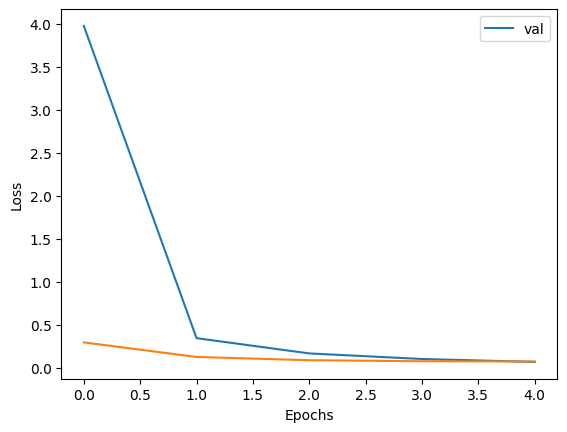

In [21]:
print(train_params['max_len_seq'])
if train_params['action'] == 'train' or train_params['action'] == 'resume':
    trainload = GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
    valload = GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)

    train_loss, val_loss, accuracy_train, accuracy_eval ,att= run_epoch(trainload, valload, train_params['device'])

In [117]:
#Pour charger les parametre dans un nouveau modele:
#new_gnn = GraphTransformer(conf)  # Créez une nouvelle instance de GraphTransformer
#new_gnn.load_state_dict(torch.load('../../data/'+'GraphTransformer_pretrain_1' + '.pch'))

In [42]:
ex = list(dataset[0][-3].x.detach().numpy())
q= att[0][0].to('cpu').detach().numpy()
k= att[0][0].to('cpu').detach().numpy()
q = q[:,ex]
k = k[:,ex]
a= q.T@k

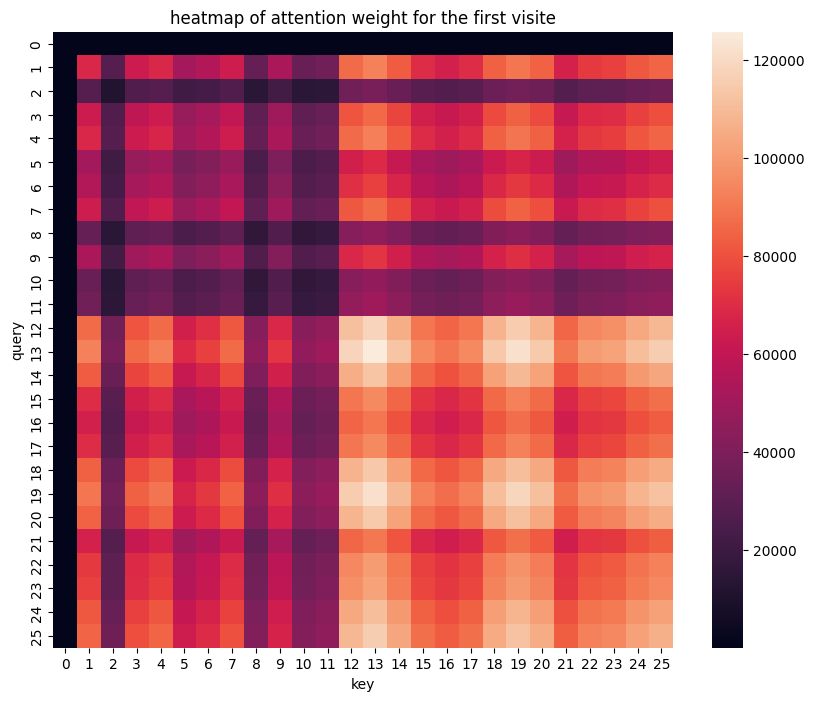

In [47]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(a)
plt.title("heatmap of attention weight for the first visite")
plt.ylabel("query")
plt.xlabel("key")
plt.show()

In [135]:
with open('../../data/dic_global_reverse.pkl', 'rb') as handle:
    dic = pickle.load(handle)

dic = {int(k)+6: v['element'] for k, v in dic.items()}
dic[0] = 'VST'
print(dic[0])

VST


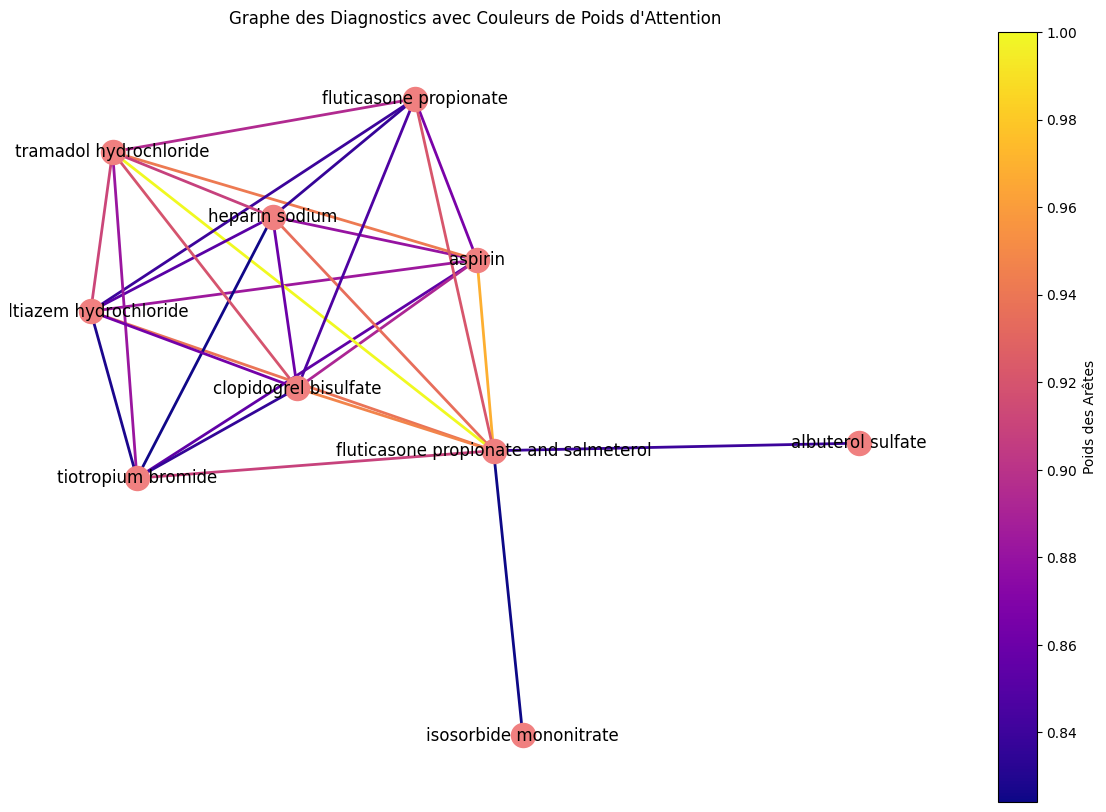

In [134]:


# Exemple de données pour le graphe
# Liste de vos noeuds (diagnostics)
nodes = ex
n = len(nodes)

# Votre matrice d'attention (ici, un exemple aléatoire)
attention_matrix =  a
min_val = attention_matrix.min()
max_val = attention_matrix.max()

# Normalisation de la matrice
attention_matrix = (attention_matrix - min_val) / (max_val - min_val)

# Création du graphe
G = nx.Graph()


# Définir un seuil
threshold = 0.8  # Ajustez cette valeur selon vos besoins

# Ajout des arêtes avec les poids issus de la matrice d'attention, en respectant le seuil
for i in range(n):
    for j in range(n):
        if (i != j and attention_matrix[i][j] >= threshold): #or (i != j and i==0) or (i != j and i==0):
            G.add_edge(nodes[i], nodes[j], weight=attention_matrix[i][j])


# Normalisation des poids des arêtes pour la coloration
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
max_weight = edge_weights.max()
normalized_weights = edge_weights / max_weight


labels = {node: dic[node] for node in G.nodes()}

# Palette de couleurs pour les arêtes
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=normalized_weights.min(), vmax=normalized_weights.max())
edge_colors = [cmap(norm(w)) for w in normalized_weights]

# Augmentation de la taille du graphique
fig, ax = plt.subplots(figsize=(15, 10))

# Choix d'un nouvel agencement des nœuds
pos = nx.kamada_kawai_layout(G)  # ou nx.random_layout(G), nx.shell_layout(G), etc.

# Dessiner le graphe avec des couleurs d'arête
nx.draw(G, pos, with_labels=False, edge_color=edge_colors, node_color='lightcoral', width=2)
nx.draw_networkx_labels(G, pos, labels=labels)

# Optionnel : Créer une barre de couleur pour la légende
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Poids des Arêtes')

# Afficher la visualisation
plt.title("Graphe des Diagnostics avec Couleurs de Poids d'Attention")
plt.show()
